## Score calculation from extracted scores

In [227]:
! pip -q install transformers
! pip -q install numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [228]:
import os
import numpy as np
import re
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from transformers import AutoTokenizer

In [229]:
## Get the tokenizer for a model


model_map = {"cambridgeltl":"cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR",
             "dilbert":"beatrice-portelli/DiLBERT",
             "bert-fi":"TurkuNLP/bert-base-finnish-cased-v1",
             "biomed-roberta": "allenai/biomed_roberta_base",
             "bert-en": "google-bert/bert-base-cased",
             "bert-es": "dccuchile/bert-base-spanish-wwm-uncased",
             "biomed-es":"PlanTL-GOB-ES/roberta-base-biomedical-clinical-es"}


lang = "en"
split = "dev"
model = "cambridgeltl"

tokenizer = AutoTokenizer.from_pretrained(model_map.get(model,model) if model != "cambridgeltl" else "xlm-roberta-base")

In [230]:
from itertools import zip_longest

def flatten(xss):
    return [x for xs in xss for x in xs]

def reverse_annotations(text):
    """
    Reverse MEDDOCAN + deepL annotations
    E.g. Name: [#3 Joseo]
    to
    Name: Joseo
    """

    i = re.finditer(r'\[\#[0-9]{1,2}[ ].+?\]', text)
    ind = [[m.start(0),m.end(0)] for m in i]
    current_index=0
    parsed_text=""
    annotations=[]
    for start, end in ind:
        parsed_text = parsed_text + text[current_index:start]
        annot = text[start:end].split(" ")
        pii_class = annot[0].replace("[","")
        annot_text = " ".join(annot[1:]).replace("]","")
        parsed_text += annot_text
        current_index = end
        annotations.append([pii_class, len(parsed_text)-len(annot_text), len(parsed_text)])
    #print(annotations)
    return parsed_text, annotations

# Function to parse TSV data into (word, score) pairs
def parse_tsv_data(tsv_data):
    scores = []
    words = []
    for line in tsv_data.strip().split('\n'):
        score, word, _ = line.split("\t",2)
        scores.append(float(score))
        words.append(str(word))
    return scores, words

def create_annotation_token_mask(char_offsets, detokenized, annotations_per_char, use_tags = False):
    """Create a vector with values corresponding to each token-annotation pair."""
    current_annot = 0
    continuation = False
    annotation_mask = []
    for token, (start, end) in zip(detokenized, char_offsets):
        try:
            c_type, c_start, c_end = annotations_per_char[current_annot]
        except IndexError:
            c_type, c_start, c_end = "#0",0,0
        if start == c_start or continuation:
            continuation=False
            if c_end > end:
                continuation = True
                #print(f"{token} [{start}, {end}] \t {c_type}")
                annotation_mask.append(c_type if use_tags else int(c_type[1:]))
                continue
            #print(f"{token} [{start}, {end}] \t {c_type}")
            annotation_mask.append(c_type if use_tags else int(c_type[1:]))
            current_annot += 1
        else:
            #print(f"{token} [{start}, {end}]")
            annotation_mask.append(None if use_tags else 0)
    return annotation_mask


def create_redaction_word_mask(scores, th):
    """Create a mask to see which words should be redacted."""
    return [1 if float(s) < th else 0 for s in scores]


def calculate_metrics(files):

    full_dev_scores = []
    full_dev_annotation_mask = []
    full_input_ids = []

    for file in files:
        try:
            #print("\n", file)
            file_annot = file.replace(f"zeroshot/scores_by_token/{lang}/{split}/{model}",f"deepl/translated_with_annotations/{lang}/{split}").replace("_by_token.tsv", ".txt")
            with open(file,"r") as f:
                scores = f.read()
            with open(file_annot, "r") as f:
                annots = f.read()

            # parse scored words
            scores, words = parse_tsv_data(scores)
            #print(words)
            # un-annotate, get annotations as locations by char
            parsed_original_text, annotations_per_char = reverse_annotations(annots)
            # tokenize un-annotated text, return character indices
            tokenized = tokenizer(parsed_original_text, return_offsets_mapping=True)
            char_offsets = tokenized["offset_mapping"]
            # get token divisions
            retokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"])
            annotation_token_mask = create_annotation_token_mask(char_offsets, retokens, annotations_per_char)
            #print(f"scores {len(scores)}, tokenized {len(tokenized["input_ids"])}")

            
            additional_removal = [6] if model in ["xlm-roberta-base", "cambridgeltl"] else []
            annotation_token_mask = [i for i,v in zip(annotation_token_mask,tokenized["input_ids"]) if v not in tokenizer.all_special_ids + additional_removal]
            full_input_ids.append([i for i in tokenized["input_ids"] if i not in tokenizer.all_special_ids + additional_removal])
            
            prev_i = ""
            for ind,(i,j,k) in enumerate(zip_longest(words, annotation_token_mask, full_input_ids[-1])):
                ret = tokenizer.decode(k)
                if i != ret:
                    if i == prev_i:   # common error in xlm-r
                        try:
                            words.pop(ind)   # duplicate word
                            scores.pop(ind)   # duplicate score <- this is because of the context masking
                            #print(f'popped {ind}')
                        except:
                            print(f"tried to pop index {ind} of {len(words)}")
                prev_i = i
                #print(words[ind],annotation_token_mask[ind])
            assert len(annotation_token_mask) == len(words), f"annotations {len(annotation_token_mask)}, words {len(words)}"
            #print(annotation_token_mask)

            # now, move from token to word level!
            #current_idx = -1
            #annotation_word_mask = []
            #for w_idx, mask, ret in zip(tokenized.word_ids(), annotation_token_mask, retokens):
            #    if w_idx is not None:
            #        if w_idx != current_idx:
            #            print(f"{words[w_idx]} \t {scores[w_idx]} \t {mask if mask is not None else ''} ({ret})")
            #           #annotation_word_mask.append(mask)
            #            current_idx = w_idx
            #        else:
            #            print(f"\t{words[w_idx]} \t {scores[w_idx]} \t {mask if mask is not None else ''} ({ret})")
            #assert len(annotation_word_mask) == len(words), f"{len(annotation_word_mask)} != {len(words)}" # (==len(scores), but we know that from previous)
            annotation_word_mask = annotation_token_mask
            # HERE TODO: select which tags to analyse
            annotation_word_mask = [1 if a > 0 else 0 for a in annotation_word_mask]
            #for w_, s_, a_ in zip(words, scores, annotation_word_mask):
            #    if "##" in w_:
            #        print(f"\t {w_}, {s_}, {a_ if a_ >0 else ''}")
            #    else:
            #    print((f"{w_}, {s_}, {a_ if a_ >0 else ''}"))
            assert len(annotation_token_mask) == len(words), f"annotations {len(annotation_token_mask)}, words {len(words)}"
            assert len(scores) == len(annotation_word_mask), f"scores {len(scores)}, annot {len(annotation_word_mask)}"
            full_dev_scores.append(scores)
            full_dev_annotation_mask.append(annotation_word_mask)
        except Exception as e:
            print(f'problem with {file}: {e}')
            if len(full_dev_annotation_mask) < len(full_input_ids):
                full_input_ids = full_input_ids[:-1]
    accuracies = []
    f1s = []
    recalls = []
    precisions = []
    rocs = []
    full_dev_scores_flattened = flatten(full_dev_scores)
    full_dev_annotation_mask_flattened = flatten(full_dev_annotation_mask)

    for th in np.logspace(0, -30, 100):
        redaction_word_mask = create_redaction_word_mask(full_dev_scores_flattened, th)
        accuracies.append(accuracy_score(full_dev_annotation_mask_flattened, redaction_word_mask))
        f1s.append(f1_score(full_dev_annotation_mask_flattened, redaction_word_mask,  average="binary"))
        recalls.append(recall_score(full_dev_annotation_mask_flattened, redaction_word_mask,  average="binary"))
        precisions.append(precision_score(full_dev_annotation_mask_flattened, redaction_word_mask, average="binary"))
        rocs.append(roc_auc_score(full_dev_annotation_mask_flattened, redaction_word_mask, average="micro"))
    print(accuracies)
    print(f1s)
    print(recalls)
    print(precisions)
    print(rocs)
    return accuracies, f1s, recalls, precisions, rocs, full_input_ids, full_dev_scores, full_dev_annotation_mask


In [231]:
file_paths = os.scandir(f"/scratch/project_2009498/dippa/zeroshot/scores_by_token/{lang}/{split}/{model}/")
files = [p.path for p in file_paths if "by_token.tsv" in p.path]
print(files)

['/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S0211-69952011000400013-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S1130-05582009000600006-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S1130-05582015000100004-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S1130-01082005000800013-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S0365-66912009001100006-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S1699-695X2016000200009-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S0004-06142006000900009-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S0378-48352006000600006-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_toke

In [232]:
tokenizer.all_special_ids

[0, 2, 3, 1, 250001]

In [233]:
accuracies, f1s, recalls, precisions, rocs, full_input_ids, full_dev_scores, full_dev_annotation_mask = calculate_metrics(files)

Token indices sequence length is longer than the specified maximum sequence length for this model (1185 > 512). Running this sequence through the model will result in indexing errors


problem with /scratch/project_2009498/dippa/zeroshot/scores_by_token/en/dev/cambridgeltl/S1131-57682001000100007-2_by_token.tsv: argument 'ids': 'NoneType' object cannot be converted to 'Sequence'
[0.08488047567042835, 0.08488047567042835, 0.08488047567042835, 0.08488047567042835, 0.08488047567042835, 0.08488047567042835, 0.08488047567042835, 0.08488047567042835, 0.08488047567042835, 0.08494114791894188, 0.08494114791894188, 0.08494114791894188, 0.08494114791894188, 0.0850018201674554, 0.08506249241596893, 0.085183836912996, 0.08536585365853659, 0.0857905593981313, 0.08615459288921247, 0.08676131537434777, 0.08833879383569955, 0.08997694454556486, 0.09191845649799782, 0.09434534643853901, 0.09834971484043199, 0.10338551146705496, 0.11018080330057031, 0.11916029608057274, 0.13171945152287343, 0.14773692513044534, 0.1697609513408567, 0.19724547991748576, 0.22994782186627835, 0.26240747482101684, 0.29984225215386484, 0.3355175342798204, 0.3684625652226671, 0.3996481009586215, 0.4293168304

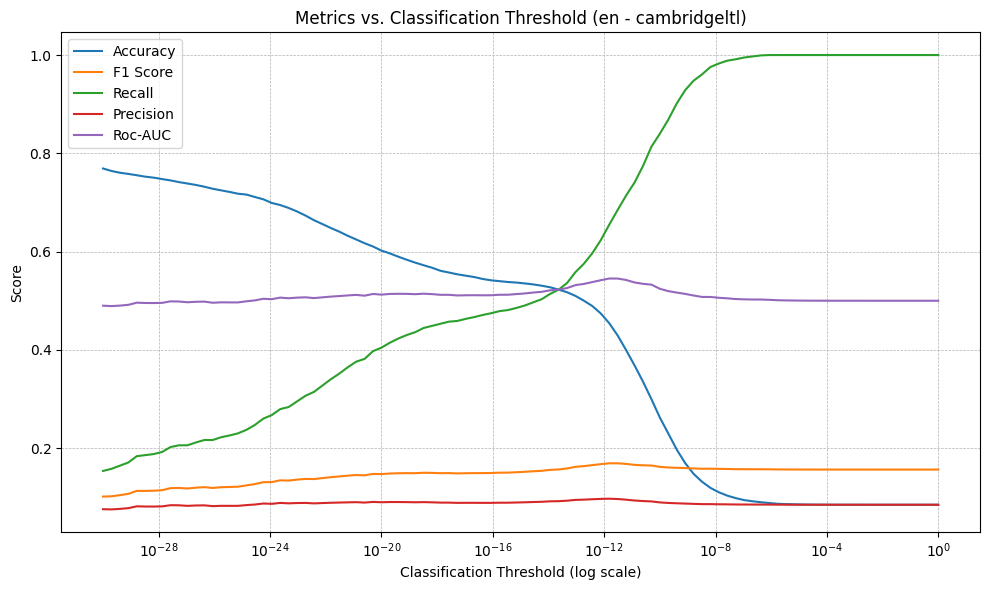

In [234]:
import matplotlib.pyplot as plt


def plot_metrics_vs_threshold(thresholds, accuracies, f1s, recalls, precisions, rocs):
    """
    Plots accuracy, F1 score, recall, and precision against classification thresholds (log scale).

    Parameters:
    - thresholds: array-like, shape (n,) – classification thresholds (logarithmic values)
    - accuracies, f1s, recalls, precisions: array-like, shape (n,) – metric values corresponding to each threshold
    """

    plt.figure(figsize=(10, 6))

    # Plot each metric
    plt.plot(thresholds, accuracies, label='Accuracy')#, marker='o')
    plt.plot(thresholds, f1s, label='F1 Score')#, marker='s')
    plt.plot(thresholds, recalls, label='Recall')#, marker='^')
    plt.plot(thresholds, precisions, label='Precision')#, marker='x')
    plt.plot(thresholds, rocs, label='Roc-AUC')#, marker='x')

    # Log scale for x-axis
    plt.xscale('log')

    # Labels and title
    plt.xlabel('Classification Threshold (log scale)')
    plt.ylabel('Score')
    plt.title(f'Metrics vs. Classification Threshold ({lang} - {model})')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics_vs_threshold(np.logspace(0, -30, 100), accuracies, f1s, recalls, precisions, rocs)

## EN - BERT-EN

![Alt text](kuva.png)

## EN - xlm-roberta-base 

![Alt text](kuva-3.png)

## EN - CambridgeLtL

![Alt text](kuva-7.png)

## FI - bert-fi

![Alt text](kuva-1.png)

## FI - xlm-roberta-base

![Alt text](kuva-4.png)

## ES - es-bert

![Alt text](kuva-2.png)


## ES xlm-roberta-base

![Alt text](kuva-5.png)

## ES - Cambridgeltl

![Alt text](kuva-6.png)

## Visualisation

In [235]:
! pip -q install IPython

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [236]:
from IPython.display import display, HTML
#import captum

"""
(Sentence as string+labels per character)
-> (array of words and label per word).
"""
def make_into_array(words, x):
  new_words = [""]
  new_x = np.array([0+0j])
  word_idx=0
  for letter, value in zip(words, x):
    if letter != " ": # word boundary
      new_words[word_idx]+=letter
      new_x[word_idx] = value
    else:
      word_idx += 1
      new_words.append("")
      new_x = np.append(new_x, 0+0j)
  assert len(new_words) == len(new_x)
  return new_words, new_x


"""
Rewrite form captum-library. Choose color based on attribute.
"""
def _get_color(attr):
    if attr == 1: # only in pred = red
        hue, sat, lig = 3, 100,	69
    elif attr == 1j: # only in true = yellow
        hue, sat, lig = 55, 90, 70
    elif attr == 1+1j:# both == green
        #hue, sat, lig = 120, 75,50
        hue, sat, lig = 120, 30, 70
    else:   # white
        hue, sat, lig = 10, 0, 100
    return "hsl({}, {}%, {}%)".format(hue, sat, lig)

def parse_token(t):
  if model in ["bert-fi", "bert-en", "bert-es"]:
    if "##" in t:
      return t[2:]
    else:
      return " "+t
  else:
    return t

"""
Rewrite from captum-library. Get formatting for html.
"""
def format_word_importances(words, importances):
    #words, importances = make_into_array(words,importances)
    if importances is None or len(importances) == 0:
        return "<td></td>"
    assert len(words) == len(importances), f"{len(words)} {len(importances)}"
    tags = ["<td>"]
    for word, importance in zip(words, importances):#[: len(words)]):
        #word = format_special_tokens(word)
        color = _get_color(importance)
        unwrapped_tag = '<mark style="background-color:{color}; opacity:1.0; \
                    line-height:1.75"><font color="black">{word}\
                    </font></mark>'.format(
            color=color, word=parse_token(tokenizer.decode(word))
        )
        tags.append(unwrapped_tag)
    tags.append("</td>")
    return "".join(tags)

"""
Highlight both correct answers and predictions.
Three colors => complex importances.
  real values = correct answer
  imaginary values = predicted answer
  both = predicted correctly

Displays as html.
"""
def display_both(dict):
  words = dict["context"]
  x_p = lambda x: dict["pred"]["start"]<= x <= dict["pred"]["end"]
  x_t = lambda x: dict["correct"]["start"]<= x <= dict["correct"]["end"]
  pred_x = np.array([1j*complex(x_p(i)) for i in range(len(words))])
  true_x = np.array([complex(x_t(i)) for i in range(len(words))])

  difference_x = true_x+pred_x
  y = format_word_importances(words,difference_x)
  display(HTML(y))

def display_predict_and_annot(text, predict, annot):
    #print(predict)
    #print(annot)
    pred_x = np.array(predict) #np.array([1j*complex(x_p(i)) for i in range(len(words))])
    true_x = np.array([1j if i == 1 else 0 for i in annot])
    difference_x = true_x+pred_x
    #print(difference_x)
    y = format_word_importances(text,difference_x)
    display(HTML(y))

In [238]:

for t, s, a in zip(full_input_ids, full_dev_scores, full_dev_annotation_mask):
    pred = s
    annot = a
    assert len(t) == len(pred)
    #print(t)
    pred = create_redaction_word_mask(pred, 1e-12)

    display_predict_and_annot(t, pred, annot)
    print("--------------------------------")

--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------
